<a href="https://colab.research.google.com/github/shriram-pophale901/DMVPR/blob/main/assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from IPython.display import clear_output
import time

In [ ]:
class MazeEnv:
    """
    Simple grid-world maze:
      0 = free cell
      1 = wall/obstacle
      2 = start
      3 = goal
    Agent actions: 0=up,1=right,2=down,3=left
    Reward: -0.1 per step, +10 for goal, -5 for hitting wall (stays in place)
    """
    def __init__(self, grid):
        self.grid = np.array(grid)
        self.h, self.w = self.grid.shape
        self.start_pos = tuple(map(int, np.argwhere(self.grid == 2)[0]))
        self.goal_pos = tuple(map(int, np.argwhere(self.grid == 3)[0]))
        self.reset()

    def reset(self):
        self.agent_pos = self.start_pos
        return self._pos_to_state(self.agent_pos)

    def _pos_to_state(self, pos):
        return pos[0] * self.w + pos[1]

    def _state_to_pos(self, s):
        return (s // self.w, s % self.w)

    def step(self, action):
        # Compute intended new position
        r, c = self.agent_pos
        if action == 0:    # up
            nr, nc = r - 1, c
        elif action == 1:  # right
            nr, nc = r, c + 1
        elif action == 2:  # down
            nr, nc = r + 1, c
        elif action == 3:  # left
            nr, nc = r, c - 1
        else:
            raise ValueError("Invalid action")

        # Check bounds
        if not (0 <= nr < self.h and 0 <= nc < self.w):
            # hitting boundary treated as wall
            reward = -5.0
            done = False
            next_state = self._pos_to_state(self.agent_pos)
            return next_state, reward, done, {}

        # Check cell content
        cell = self.grid[nr, nc]
        if cell == 1:
            # wall: stay in place
            reward = -5.0
            next_state = self._pos_to_state(self.agent_pos)
            done = False
        else:
            # move to new cell
            self.agent_pos = (nr, nc)
            if cell == 3:  # goal
                reward = 10.0
                done = True
            else:
                reward = -0.1
                done = False
            next_state = self._pos_to_state(self.agent_pos)

        return next_state, reward, done, {}

    def render(self, q_table=None, show_q=False):
        # Render grid with agent, optional Q-values overlay
        display_grid = self.grid.copy()
        r, c = self.agent_pos
        # use 4 for agent display
        display_grid[r, c] = 4

        cmap = colors.ListedColormap(['white', 'black', 'lightgreen', 'gold', 'red'])
        bounds = [0,1,2,3,4,5]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(5,5))
        plt.imshow(display_grid, cmap=cmap, norm=norm)
        plt.xticks([])
        plt.yticks([])
        plt.title("Maze - Agent (red), Start (lightgreen), Goal (gold), Wall (black)")
        plt.show()

        if show_q and q_table is not None:
            # show Q-values for each cell (max Q per state)
            max_q = np.zeros((self.h, self.w))
            for s in range(self.h * self.w):
                r_, c_ = self._state_to_pos(s)
                if self.grid[r_, c_] != 1:  # not wall
                    max_q[r_, c_] = np.max(q_table[s])
                else:
                    max_q[r_, c_] = np.nan
            plt.figure(figsize=(5,5))
            plt.imshow(max_q, cmap='cool', interpolation='nearest')
            plt.colorbar(label='max Q')
            plt.title('Max Q-value per cell (NaN = wall)')
            plt.show()

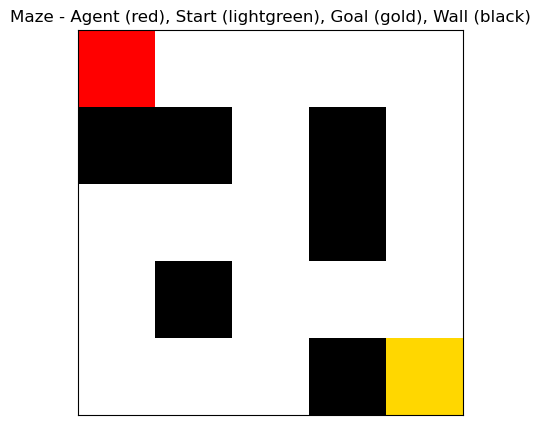

In [ ]:
# 0 free, 1 wall, 2 start, 3 goal
maze = [
    [2, 0, 0, 0, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 3]
]

env = MazeEnv(maze)
env.render()

In [ ]:

def q_learning(env, episodes=2000, alpha=0.7, gamma=0.9, epsilon=1.0, eps_decay=0.995, min_epsilon=0.01, max_steps=200):
    n_states = env.h * env.w
    n_actions = 4
    Q = np.zeros((n_states, n_actions))

    rewards_per_episode = []
    success_rate = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        done = False

        for step in range(max_steps):
            # choose action: epsilon-greedy
            if random.random() < epsilon:
                action = random.randint(0, n_actions-1)
            else:
                # choose best action (break ties randomly)
                max_a = np.flatnonzero(Q[state] == Q[state].max())
                action = np.random.choice(max_a)

            next_state, reward, done, _ = env.step(action)

            # Q update
            old_q = Q[state, action]
            Q[state, action] = old_q + alpha * (reward + gamma * np.max(Q[next_state]) - old_q)

            state = next_state
            total_reward += reward

            if done:
                break

        # decay epsilon
        epsilon = max(min_epsilon, epsilon * eps_decay)
        rewards_per_episode.append(total_reward)
        # record whether reached goal
        success_rate.append(1 if done else 0)

        # periodic status
        if (ep+1) % 200 == 0:
            clear_output(wait=True)
            print(f"Episode {ep+1}/{episodes} | Avg reward (last 100): {np.mean(rewards_per_episode[-100:]):.2f} | Epsilon: {epsilon:.3f} | Success rate (last 100): {np.mean(success_rate[-100:])*100:.1f}%")

    return Q, rewards_per_episode, success_rate

# Train
Q, rewards, success = q_learning(env, episodes=2000, alpha=0.7, gamma=0.95, epsilon=1.0, eps_decay=0.995, min_epsilon=0.01)


Episode 2000/2000 | Avg reward (last 100): 9.10 | Epsilon: 0.010 | Success rate (last 100): 100.0%


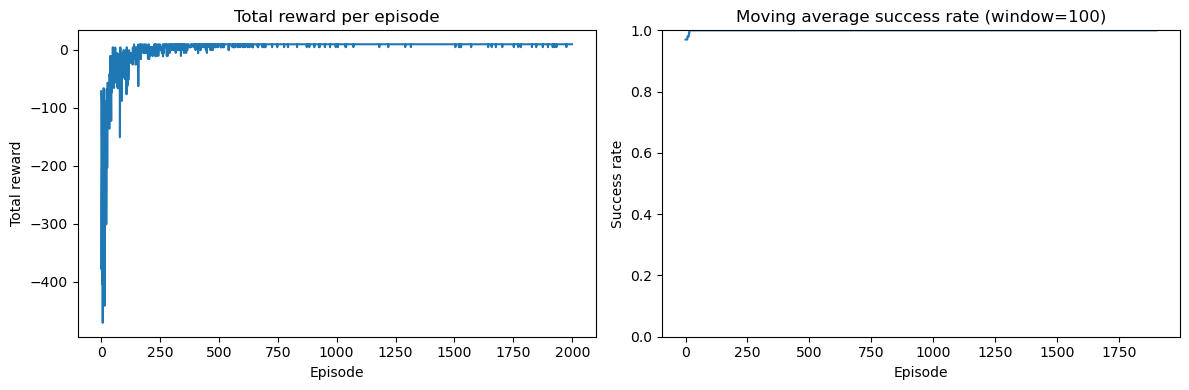

In [ ]:
# Cell 5: Plot training curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(rewards)
plt.title("Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")

plt.subplot(1,2,2)
# moving average for success rate
win_rate = np.convolve(success, np.ones(100)/100, mode='valid')
plt.plot(win_rate)
plt.title("Moving average success rate (window=100)")
plt.xlabel("Episode")
plt.ylabel("Success rate")
plt.ylim(0,1)

plt.tight_layout()
plt.show()


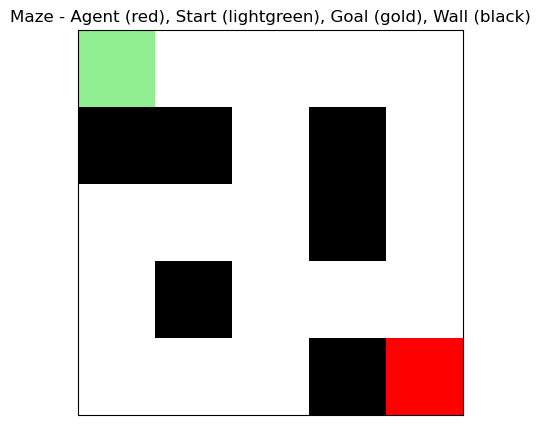

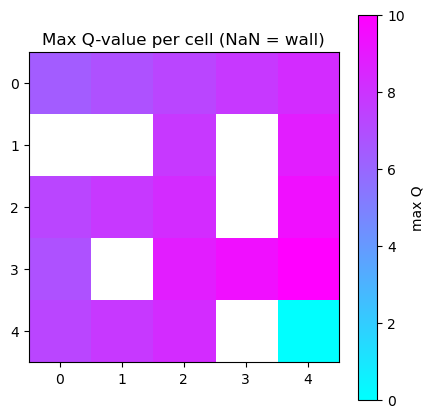

Greedy run steps: 8 Reached goal: True


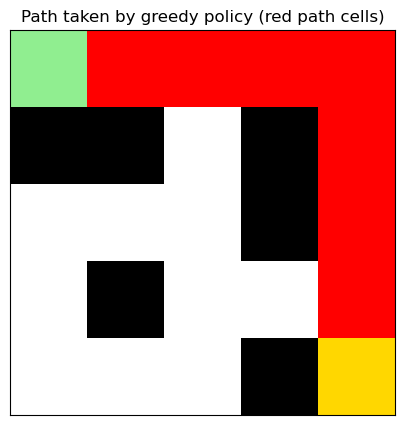

In [ ]:
# Cell 6: Visualize learned policy and run one greedy episode
def get_policy_from_q(Q, env):
    policy = {}
    for s in range(env.h * env.w):
        r, c = env._state_to_pos(s)
        if env.grid[r, c] == 1:
            policy[s] = None
        else:
            policy[s] = np.argmax(Q[s])
    return policy

policy = get_policy_from_q(Q, env)

# Show max Q per cell heatmap
env.render(q_table=Q, show_q=True)

# Execute one greedy run and show steps
state = env.reset()
path = [env.agent_pos]
done = False
steps = 0
while not done and steps < 200:
    action = policy[state]
    if action is None:
        print("Policy has no action (wall).")
        break
    state, reward, done, _ = env.step(action)
    path.append(env.agent_pos)
    steps += 1

print("Greedy run steps:", steps, "Reached goal:", done)
# display path overlay on maze
grid_vis = env.grid.copy()
for (r,c) in path:
    if grid_vis[r,c] == 0:
        grid_vis[r,c] = 4  # path color
grid_vis[env.start_pos] = 2
grid_vis[env.goal_pos] = 3

cmap = colors.ListedColormap(['white', 'black', 'lightgreen', 'gold', 'red'])
plt.figure(figsize=(5,5))
plt.imshow(grid_vis, cmap=cmap, norm=colors.BoundaryNorm([0,1,2,3,4,5], cmap.N))
plt.title("Path taken by greedy policy (red path cells)")
plt.xticks([]); plt.yticks([])
plt.show()
